# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig

# Set config

In [3]:
llm_config = LLMConfig(
    vocab_size=2_000,
    context_size=64,
    dim_emb=512,
    num_layers=4,
    num_heads=8,
    emb_dropout=0.0,
    ffd_bias=True,
    ffd_dropout=0.0,
)

train_config = TrainingConfig(
    retrain_tokenizer=True, batch_size=64, learning_rate=1e-4, weight_decay=1e-5, max_steps=4_000, log_frequency=1
)

# Prepare tokenizer and dataset


In [4]:
input_file = "../data/shakespeare/tinyshakespeare.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../data/shakespeare/tinyshakespeare.txt
  input_format: 
  model_prefix: ../data/shakespeare/tinyshakespeare
  model_type: UNIGRAM
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 1000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_d

In [5]:
sentence = "The role of the tokenizer is to build a mapping between a sentences represented as a string and token indices"
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁', 'ro', 'le', '▁of', '▁the', '▁to', 'k', 'en', 'ize', 'r', '▁is', '▁to', '▁bu', 'il', 'd', '▁a', '▁m', 'app', 'ing', '▁between', '▁a', '▁sentence', 's', '▁re', 'p', 're', 's', 'ent', 'ed', '▁as', '▁a', '▁str', 'ing', '▁and', '▁to', 'k', 'en', '▁in', 'd', 'ice', 's']


In [6]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

X, y = ds_train.get_batch(batch_size=1)

print(X.shape, y.shape)


torch.Size([1, 64]) torch.Size([1, 64])


# Define model


In [7]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_bias=llm_config.ffd_bias,
    ffd_dropout=llm_config.ffd_dropout
)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"learnable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,d}")
print(f"model size: {size_all_mb:.3f}MB")

#print(model)

total params: 10,451,408
learnable params: 10,451,408
model size: 40.010MB


# Train model


In [8]:
loss_history = train(
    model,
    ds_train,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

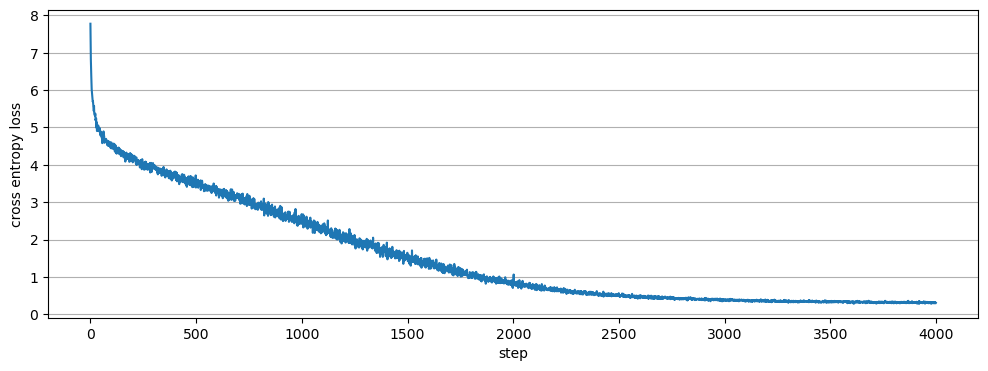

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

# Play around

In [16]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

"'s endsant. What cheer of rottens he in these wants? Looks? Why comest thou in these arms? If thou"

In [19]:
# generate from a prompt
prompt = tokenizer.encode("To be, or not to be: that is the question.", beg_of_string=True, pad_seq=True, seq_len=llm_config.context_size).view(1, -1)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'To be, or not to be: that is the question. KING RICHARD III: But in your mouth of these deaths, if I be not of your woes, But you loseld till my'